In [1]:
import pandas as pd

data = pd.read_csv("data/20240114_015.csv", sep=";", encoding="iso-8859-1")
data.head()

,MONSTER_IDENTIFICATIE,MEETPUNT_IDENTIFICATIE,LOCATIE_CODE,TYPERING_OMSCHRIJVING,TYPERING_CODE,GROOTHEID_OMSCHRIJVING,GROOTHEID_ CODE,PARAMETER_OMSCHRIJVING,PARAMETER_ CODE,CAS_NR,...,EPSG,X,Y,ORGAAN_OMSCHRIJVING,ORGAAN_CODE,TAXON_NAME,GROEPERING_OMSCHRIJVING,GROEPERING_CODE,GROEPERING_KANAAL,GROEPERING_TYPE
0,NaN,ADM Noordervaart,NVAA,NaN,NaN,Waterhoogte,WATHTE,NaN,NaN,NaN,...,25831,"693210,50110918","5684665,23606331",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ADM Noordervaart,NVAA,NaN,NaN,Waterhoogte,WATHTE,NaN,NaN,NaN,...,25831,"693210,50110918","5684665,23606331",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,ADM Noordervaart,NVAA,NaN,NaN,Waterhoogte,WATHTE,NaN,NaN,NaN,...,25831,"693210,50110918","5684665,23606331",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,ADM Noordervaart,NVAA,NaN,NaN,Waterhoogte,WATHTE,NaN,NaN,NaN,...,25831,"693210,50110918","5684665,23606331",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,ADM Noordervaart,NVAA,NaN,NaN,Waterhoogte,WATHTE,NaN,NaN,NaN,...,25831,"693210,50110918","5684665,23606331",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Drop empty columns
data = data.dropna(axis="columns", how="all")
data.head()

,MEETPUNT_IDENTIFICATIE,LOCATIE_CODE,GROOTHEID_OMSCHRIJVING,GROOTHEID_ CODE,EENHEID_CODE,HOEDANIGHEID_OMSCHRIJVING,HOEDANIGHEID_CODE,COMPARTIMENT_OMSCHRIJVING,COMPARTIMENT_CODE,WAARDEBEPALINGSMETHODE_OMSCHRIJVING,...,KWALITEITSOORDEEL_CODE,STATUSWAARDE,OPDRACHTGEVENDE_INSTANTIE,MEETAPPARAAT_OMSCHRIJVING,MEETAPPARAAT_CODE,BEMONSTERINGSHOOGTE,REFERENTIEVLAK,EPSG,X,Y
0,ADM Noordervaart,NVAA,Waterhoogte,WATHTE,cm,t.o.v. Normaal Amsterdams Peil,NAP,Oppervlaktewater,OW,Rekenkundig gemiddelde waarde over vorige 5 en...,...,Normale waarde,Ongecontroleerd,LMW_WATERSTANDEN,Vlotter,127.0,-999999999,NVT,25831,"693210,50110918","5684665,23606331"
1,ADM Noordervaart,NVAA,Waterhoogte,WATHTE,cm,t.o.v. Normaal Amsterdams Peil,NAP,Oppervlaktewater,OW,Rekenkundig gemiddelde waarde over vorige 5 en...,...,Normale waarde,Ongecontroleerd,LMW_WATERSTANDEN,Vlotter,127.0,-999999999,NVT,25831,"693210,50110918","5684665,23606331"
2,ADM Noordervaart,NVAA,Waterhoogte,WATHTE,cm,t.o.v. Normaal Amsterdams Peil,NAP,Oppervlaktewater,OW,Rekenkundig gemiddelde waarde over vorige 5 en...,...,Normale waarde,Ongecontroleerd,LMW_WATERSTANDEN,Vlotter,127.0,-999999999,NVT,25831,"693210,50110918","5684665,23606331"
3,ADM Noordervaart,NVAA,Waterhoogte,WATHTE,cm,t.o.v. Normaal Amsterdams Peil,NAP,Oppervlaktewater,OW,Rekenkundig gemiddelde waarde over vorige 5 en...,...,Normale waarde,Ongecontroleerd,LMW_WATERSTANDEN,Vlotter,127.0,-999999999,NVT,25831,"693210,50110918","5684665,23606331"
4,ADM Noordervaart,NVAA,Waterhoogte,WATHTE,cm,t.o.v. Normaal Amsterdams Peil,NAP,Oppervlaktewater,OW,Rekenkundig gemiddelde waarde over vorige 5 en...,...,Normale waarde,Ongecontroleerd,LMW_WATERSTANDEN,Vlotter,127.0,-999999999,NVT,25831,"693210,50110918","5684665,23606331"


In [3]:
# Drop columns that have all the same value
same_cols = []
metadata = {}

for colname in data.columns:
    values = data[colname].tolist()
    if len(set(values)) == 1:
        # print(f"Column {colname} is unique with value {col[0]}")
        same_cols.append(colname)
        metadata[colname] = values[0]

metadata

{'GROOTHEID_OMSCHRIJVING': 'Waterhoogte',
 'GROOTHEID_ CODE': 'WATHTE',
 'EENHEID_CODE': 'cm',
 'HOEDANIGHEID_OMSCHRIJVING': 't.o.v. Normaal Amsterdams Peil',
 'HOEDANIGHEID_CODE': 'NAP',
 'COMPARTIMENT_OMSCHRIJVING': 'Oppervlaktewater',
 'COMPARTIMENT_CODE': 'OW',
 'STATUSWAARDE': 'Ongecontroleerd',
 'OPDRACHTGEVENDE_INSTANTIE': 'LMW_WATERSTANDEN',
 'EPSG': 25831}

In [4]:
data = data.drop(columns=same_cols)
data.head()

,MEETPUNT_IDENTIFICATIE,LOCATIE_CODE,WAARDEBEPALINGSMETHODE_OMSCHRIJVING,WAARDEBEPALINGSMETHODE_CODE,BEMONSTERINGSSOORT_OMSCHRIJVING,BEMONSTERINGSSOORT_CODE,WAARNEMINGDATUM,WAARNEMINGTIJD (MET/CET),NUMERIEKEWAARDE,KWALITEITSOORDEEL_CODE,MEETAPPARAAT_OMSCHRIJVING,MEETAPPARAAT_CODE,BEMONSTERINGSHOOGTE,REFERENTIEVLAK,X,Y
0,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:00:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331"
1,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:10:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331"
2,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:20:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331"
3,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:30:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331"
4,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:40:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331"


In [5]:
# add proper datetime column
from datetime import datetime

# TODO this is very slow
data["DATUMTIJD"] = data.apply(lambda x: datetime.strptime(x['WAARNEMINGDATUM'] + " " + x['WAARNEMINGTIJD (MET/CET)'], "%d-%m-%Y %H:%M:%S"), axis=1)
data.head()

,MEETPUNT_IDENTIFICATIE,LOCATIE_CODE,WAARDEBEPALINGSMETHODE_OMSCHRIJVING,WAARDEBEPALINGSMETHODE_CODE,BEMONSTERINGSSOORT_OMSCHRIJVING,BEMONSTERINGSSOORT_CODE,WAARNEMINGDATUM,WAARNEMINGTIJD (MET/CET),NUMERIEKEWAARDE,KWALITEITSOORDEEL_CODE,MEETAPPARAAT_OMSCHRIJVING,MEETAPPARAAT_CODE,BEMONSTERINGSHOOGTE,REFERENTIEVLAK,X,Y,DATUMTIJD
0,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:00:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331",2023-12-01 00:00:00
1,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:10:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331",2023-12-01 00:10:00
2,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:20:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331",2023-12-01 00:20:00
3,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:30:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331",2023-12-01 00:30:00
4,ADM Noordervaart,NVAA,Rekenkundig gemiddelde waarde over vorige 5 en...,other:F007,Steekbemonstering,SB,01-12-2023,00:40:00,3163,Normale waarde,Vlotter,127.0,-999999999,NVT,"693210,50110918","5684665,23606331",2023-12-01 00:40:00


In [6]:
# convert X and Y to proper floats
for c in ["X", "Y"]:
    data[c] = data[c].str.replace(",", ".").astype(float)


In [7]:
# remove rows where X or Y is 0
data = data[data.X != 0]
data = data[data.Y != 0]

In [8]:
# create locations gdf
import geopandas as gpd

key_col = "LOCATIE_CODE"
attr_cols = ["MEETPUNT_IDENTIFICATIE", "X", "Y"]

locations = data.groupby(by=key_col)[attr_cols].first()
locations = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations["X"], locations["Y"], crs="EPSG:25831"))

locations.head()

,MEETPUNT_IDENTIFICATIE,X,Y,geometry
LOCATIE_CODE,,,,
AADP,Aadorp,747296.179521,5.808689e+06,POINT (747296.180 5808689.096)
ALME,Almen,724630.236454,5.784599e+06,POINT (724630.236 5784598.641)
AMHV,Amaliahaven,568361.253568,5.757300e+06,POINT (568361.254 5757300.400)
AMRB,Amerongen boven,665657.636316,5.761131e+06,POINT (665657.636 5761130.559)
AMRO,Amerongen beneden,665152.504311,5.760974e+06,POINT (665152.504 5760973.893)


In [9]:
# convert CRS and scale to -1, 1
locations = locations.to_crs(epsg=28992)

locations["SCALED_X"] = (locations.geometry.x - 155_000) / (325_000 / 2)
locations["SCALED_Y"] = (locations.geometry.y - 463_000) / (325_000 / 2)
locations = locations.round(5)

locations.head()

,MEETPUNT_IDENTIFICATIE,X,Y,geometry,SCALED_X,SCALED_Y
LOCATIE_CODE,,,,,,
AADP,Aadorp,747296.17952,5.808689e+06,POINT (239843.098 487915.962),0.52211,0.15333
ALME,Almen,724630.23645,5.784599e+06,POINT (216402.984 464593.987),0.37786,0.00981
AMHV,Amaliahaven,568361.25357,5.757300e+06,POINT (59315.341 442445.717),-0.58883,-0.12649
AMRB,Amerongen boven,665657.63632,5.761131e+06,POINT (156699.998 443080.050),0.01046,-0.12258
AMRO,Amerongen beneden,665152.50431,5.760974e+06,POINT (156190.008 442940.051),0.00732,-0.12345


In [10]:
# select columns and export
locations[["MEETPUNT_IDENTIFICATIE", "SCALED_X", "SCALED_Y"]].to_csv("output/waterhoogtes_locaties.csv", sep=",", encoding="utf-8")

In [11]:
# pivot measurements
import numpy as np
# from ipydatagrid import DataGrid

colnames = [
    "LOCATIE_CODE",
    "DATUMTIJD",
    "NUMERIEKEWAARDE",
]

pivoted = data[colnames].pivot_table(index="LOCATIE_CODE", values="NUMERIEKEWAARDE", columns="DATUMTIJD").replace(999999999.0, np.NaN)
pivoted.head()

DATUMTIJD,2023-12-01 00:00:00,2023-12-01 00:10:00,2023-12-01 00:20:00,2023-12-01 00:30:00,2023-12-01 00:40:00,2023-12-01 00:50:00,2023-12-01 01:00:00,2023-12-01 01:10:00,2023-12-01 01:20:00,2023-12-01 01:30:00,...,2024-01-14 15:40:00,2024-01-14 15:50:00,2024-01-14 16:00:00,2024-01-14 16:10:00,2024-01-14 16:20:00,2024-01-14 16:30:00,2024-01-14 16:40:00,2024-01-14 16:50:00,2024-01-14 17:00:00,2024-01-14 17:10:00
LOCATIE_CODE,,,,,,,,,,,,,,,,,,,,,
AADP,1001.0,1000.0,1000.0,1001.0,1001.0,1001.0,1002.0,1001.0,1003.0,1002.0,...,1004.0,1004.0,1003.0,1003.0,1001.0,1004.0,1000.0,1002.0,1001.0,1001.0
ALME,999.0,999.0,999.0,1000.0,999.0,999.0,999.0,998.0,998.0,999.0,...,997.0,997.0,993.0,997.0,993.0,994.0,993.0,998.0,996.0,998.0
AMHV,-46.0,-45.0,-44.0,-42.0,-40.0,-39.0,-37.0,-35.0,-35.0,-35.0,...,81.0,107.0,138.0,168.0,191.0,206.0,211.0,209.0,201.0,190.0
AMRB,476.0,476.0,476.0,476.0,476.0,476.0,475.0,476.0,475.0,476.0,...,553.0,553.0,553.0,554.0,554.0,554.0,554.0,554.0,554.0,554.0
AMRO,471.0,471.0,470.0,471.0,470.0,470.0,470.0,471.0,470.0,470.0,...,443.0,442.0,442.0,441.0,441.0,441.0,440.0,440.0,440.0,440.0


<Axes: xlabel='DATUMTIJD'>

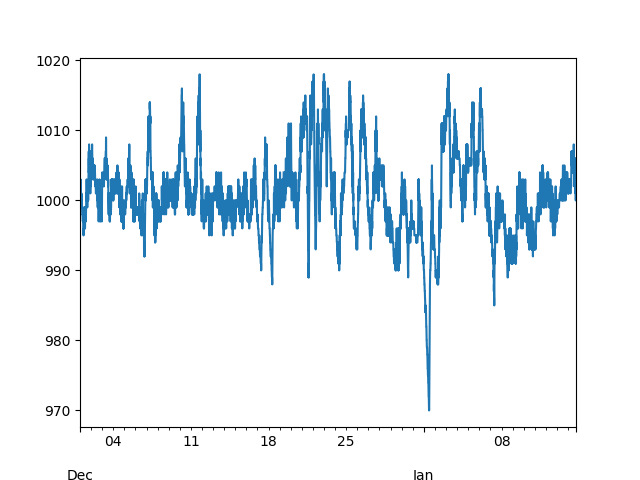

In [12]:
# plot measurements
%matplotlib ipympl
import matplotlib.pyplot as plt

pivoted.loc["AADP"].plot()


In [13]:
from ipywidgets import interact

@interact
def plot(row: int = 10):
    pivoted.iloc[row].plot()

plot()

interactive(children=(IntSlider(value=10, description='row', max=30, min=-10), Output()), _dom_classes=('widge…

In [14]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

def water_widget(name: str):
    plt.clf()
    pivoted.loc[name].plot()
    plt.show()

name_widget = widgets.Dropdown(options=pivoted.index, description="CODE")

widgets.interact(water_widget, name=name_widget)

interactive(children=(Dropdown(description='CODE', options=('AADP', 'ALME', 'AMHV', 'AMRB', 'AMRO', 'ANKA', 'A…

<function __main__.water_widget(name: str)>

In [15]:
# remove outliers
from scipy import stats

outliers = np.abs(stats.zscore(pivoted, axis=0, nan_policy="omit")) > 8

pivoted = pivoted.where(~outliers, np.nan)

In [16]:
# interpolate missing values
pivoted = pivoted.interpolate(method="linear", axis=0, limit_direction="both").astype(int)

In [17]:
# export pivoted measurements
pivoted.to_csv("output/waterhoogtes_waardes.csv", sep=",", encoding="utf-8")